In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
np.set_printoptions(precision = 3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#function to merge the dataset
def merge_csv(directory):
    files = os.listdir(directory)
    data = pd.DataFrame()
    for file in files:
        if file.endswith('.csv'):
            data = pd.concat([data, pd.read_csv(os.path.join(directory, file), usecols=["Computer timestamp", "Participant name", 'Recording name','Gaze point X','Gaze point Y', 'Pupil diameter left', 'Pupil diameter right', 'Eye movement type', 'Gaze event duration', 'Eye movement type index'])])

    return data


In [4]:
#function to read and merge the dataset into a dictionary of dataframes
def merge_csv_dict(directory):
    files = os.listdir(directory)
    data = {}
    for file in files:
        if file.endswith('.csv'):
            data[file.split('participant')[1]] = pd.read_csv(os.path.join(directory, file), usecols=["Computer timestamp", "Participant name", 'Recording name','Gaze point X','Gaze point Y', 'Pupil diameter left', 'Pupil diameter right', 'Eye movement type', 'Gaze event duration', 'Eye movement type index'])
    return data


In [5]:
#function to parse the participant id
def parse_participant_id(col):
    for i in range(0, len(col)):
        col[i] = col[i][-2:]
    return col


In [6]:
#function to parse the recording name
def parse_recording_name(col):
    for i in range(0, len(col)):
        col[i] = col[i].split('g')[1]
    return col


In [7]:
#function to compress the dataset into one row per trial
def compress_trials(df, i):
    trials_data = pd.DataFrame()
    #print(df['Participant'].i~loc[0])
    trials_data.at[i,'Participant'] = df['Participant'].iloc[0]
    trials_data.at[i,'Recording name'] = df['Recording name'].iloc[0]
    trials_data.at[i,'Gaze point X'] = df['Gaze point X'].mean()
    trials_data.at[i,'Gaze point Y'] = df['Gaze point Y'].mean()
    trials_data.at[i,'Gaze event duration - Max'] = df['Gaze event duration - Max'].mean()
    trials_data.at[i,'Left pupil (max-mean)'] = df['Left pupil (max-mean)'].mean()
    trials_data.at[i,'Right pupil (max-mean)'] = df['Right pupil (max-mean)'].mean()
    trials_data.at[i,'Left pupil (mean-min)'] = df['Left pupil (mean-min)'].mean()
    trials_data.at[i,'Right pupil (mean-min)'] = df['Right pupil (mean-min)'].mean()
    trials_data.at[i,'Eye movement type_Fixation'] = df['Eye movement type_Fixation'].mean()
    trials_data.at[i,'Eye movement type_Saccade'] = df['Eye movement type_Saccade'].mean()
    trials_data.at[i,'Eye movement type_Unclassified'] = df['Eye movement type_Unclassified'].mean()
    return trials_data



In [8]:
#automating the pre-processing
def pre_pros(df):
    df['Pupil diameter left'] = df['Pupil diameter left'].str.replace(',', '.').astype('float64')
    df['Pupil diameter right'] = df['Pupil diameter right'].str.replace(',', '.').astype('float64')
    df['Left pupil (max-mean)'] = df['Pupil diameter left'].max() - df['Pupil diameter left'].mean()
    df['Right pupil (max-mean)'] = df['Pupil diameter right'].max() - df['Pupil diameter right'].mean()
    df['Left pupil (mean-min)'] = df['Pupil diameter left'].mean() - df['Pupil diameter left'].min()
    df['Right pupil (mean-min)'] = df['Pupil diameter right'].mean() - df['Pupil diameter right'].min()
    col = {'Eye movement type'}
    df = pd.get_dummies(df, columns=col)
    df['Eye movement type_Unclassified'] = df['Eye movement type_Unclassified'].sum()
    df['Eye movement type_Saccade'] = df['Eye movement type_Saccade'].sum()
    df['Eye movement type_Fixation'] = df['Eye movement type_Fixation'].sum()
    df['Gaze event duration - Max'] = df['Gaze event duration'].max()
    df = df.reset_index()
    df['Recording name'] = parse_recording_name(df['Recording name'])
    df['Recording name'] = df['Recording name'].apply(pd.to_numeric)
    df.rename(columns={'Participant name': 'Participant'}, inplace=True)
    df['Participant'] = parse_participant_id(df['Participant'])
    df['Participant'] = df['Participant'].apply(pd.to_numeric)
    return df

In [9]:
#q_IA contains the questionnaire data 'before intervention' or before conducting the experiment
q_IA = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/19657323/Questionnaire_datasetIA.csv", encoding= 'unicode_escape')
q_IA.head()

,Participant nr,NR,Created,Modified,I have read and understood the information about the study and all the information in this form is explained to me and I am willing to participate,I want to participate.,I sometimes find it difficult to see things from the other guys point of view.,"I am usually objective when I watch a film or play, and I dont often get completely caught up in it.",I try to look at everybodys side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,"When I am upset at someone, I usually try to put myself in his shoes for a while.","Before criticising somebody, I try to imagine how I would feel if I was in their place.",I often get emotionally involved with my friends problems.,I am inclined to get nervous when others around me seem to be nervous.,People I am with have a strong influence on my mood.,It affects me very much when one of my friends seems upset.,"I often get deeply involved with the feelings of a character in a film, play or novel.",I get very upset when I see someone cry.,I am happy when I am with a cheerful group and sad when the others are glum.,It worries me when others are worrying and panicky.,I can easily tell if someone else wants to enter a conversation.,I can pick up quickly if someone says one thing but means another.,It is hard for me to see why some things upset people so much.,I find it easy to put myself in somebody elses shoes.,I am good at predicting how someone will feel.,I am quick to spot when someone in a group is feeling awkward or uncomfortable.,Other people tell me I am good at understanding how they are feeling and what they are thinking.,I can easily tell if someone else is interested or bored with what I am saying.,Friends talk to me about their problems as they say that I am very understanding.,"I can sense if I am intruding, even if the other person does not tell me.",I can easily work out what another person might want to talk about.,I can tell if someone is masking their true emotion.,I am good at predicting what someone will do.,"I can usually appreciate the other persons viewpoint, even if I do not agree with it.",I usually stay emotionally detached when watching a film.,I always try to consider the other fellows feelings before I do something.,Before I do something I try to consider how my friends will react to it.,I feel frustrated when I cannot communicate my ideas.,I complete the sentences of other people when they find it difficult to communicate their ideas to help them.,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other peoples sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original,Elapsed time
0,1,9199452,07.09.2020 15:13,07.09.2020 15:13,Yes,Proceed,3,3,4,4,3,4,3,3,2,3,3,4,4,3,3,4,3,4,4,4,4,4,4,4,3,3,3,4,3,4,4,4,4,1,4,4,4,1,3,4,134,108,5 minutes 5 seconds
1,2,9584002,30.09.2020 11:23,30.09.2020 11:23,Yes,Proceed,3,3,4,4,4,3,3,2,3,3,1,3,4,4,4,3,3,4,4,3,4,4,4,3,3,4,3,4,3,4,4,3,4,2,4,3,3,4,2,2,133,105,5 minutes 55 seconds
2,3,9112363,02.09.2020 09:17,02.09.2020 09:17,Yes,Proceed,2,2,3,4,3,3,3,3,3,3,4,4,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,2,3,3,3,3,3,3,3,116,81,6 minutes 49 seconds
3,4,9727754,06.10.2020 13:20,06.10.2020 13:20,Yes,Proceed,2,3

In [10]:
#q_IB contains the questionnaire data 'after intervention' or after conducting the experiment
q_IB = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/19657323/Questionnaire_datasetIB.csv", encoding= 'unicode_escape')
q_IB.head()

,Participant nr,NR,Created,Modified,I have read and understood the information about the study and all the information in this form is explained to me and I am willing to participate,I want to participate.,I sometimes find it difficult to see things from the other guys point of view.,"I am usually objective when I watch a film or play, and I dont often get completely caught up in it.",I try to look at everybodys side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,"When I am upset at someone, I usually try to put myself in his shoes for a while.","Before criticising somebody, I try to imagine how I would feel if I was in their place.",I often get emotionally involved with my friends problems.,I am inclined to get nervous when others around me seem to be nervous.,People I am with have a strong influence on my mood.,It affects me very much when one of my friends seems upset.,"I often get deeply involved with the feelings of a character in a film, play or novel.",I get very upset when I see someone cry.,I am happy when I am with a cheerful group and sad when the others are glum.,It worries me when others are worrying and panicky.,I can easily tell if someone else wants to enter a conversation.,I can pick up quickly if someone says one thing but means another.,It is hard for me to see why some things upset people so much.,I find it easy to put myself in somebody elses shoes.,I am good at predicting how someone will feel.,I am quick to spot when someone in a group is feeling awkward or uncomfortable.,Other people tell me I am good at understanding how they are feeling and what they are thinking.,I can easily tell if someone else is interested or bored with what I am saying.,Friends talk to me about their problems as they say that I am very understanding.,"I can sense if I am intruding, even if the other person does not tell me.",I can easily work out what another person might want to talk about.,I can tell if someone is masking their true emotion.,I am good at predicting what someone will do.,"I can usually appreciate the other persons viewpoint, even if I do not agree with it.",I usually stay emotionally detached when watching a film.,I always try to consider the other fellows feelings before I do something.,Before I do something I try to consider how my friends will react to it.,I feel frustrated when I cannot communicate my ideas.,I complete the sentences of other people when they find it difficult to communicate their ideas to help them.,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other peoples sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original,Elapsed time
0,1,9534500,24.09.2020 16:00,24.09.2020 16:00,Yes,Proceed,1,3,4,4,4,4,4,3,3,4,3,3,4,4,3,3,3,4,4,4,4,4,4,4,3,3,3,4,3,4,4,4,4,1,4,4,4,1,2,4,137,109,5 minutes 5 seconds
1,2,9597659,30.09.2020 15:14,30.09.2020 15:14,Yes,Proceed,2,2,4,4,4,4,3,3,4,4,2,3,3,3,3,3,3,3,3,3,4,3,4,3,3,3,3,4,3,4,3,3,4,2,4,3,3,4,2,2,127,100,5 minutes 55 seconds
2,3,9637453,01.10.2020 16:20,01.10.2020 16:20,Yes,Proceed,4,1,4,4,4,4,4,3,3,3,3,4,4,3,3,3,3,4,3,3,3,3,3,3,2,2,2,4,3,3,3,4,2,3,3,3,2,3,3,2,123,98,6 minutes 49 seconds
3,4,9732460,06.10.2020 16:45,06.10.2020 16:45,Yes,Proceed,2,3

In [11]:
replace_struct = {'It is hard for me to see why some things upset people so much.':{1:4, 2:3, 3:2, 4:1},
                 'I am good at predicting how someone will feel.':{1:4, 2:3, 3:2, 4:1},
                 'I usually stay emotionally detached when watching a film.':{1:4, 2:3, 3:2, 4:1},
                 'I always try to consider the other fellows feelings before I do something.':{1:4, 2:3, 3:2, 4:1},
                 'If someone is suffering from stutter, I prefer speaking rather than texting.':{1:4, 2:3, 3:2, 4:1},
                 'In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.':{1:4, 2:3, 3:2, 4:1},
                 'In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.':{1:4, 2:3, 3:2, 4:1},
                 'I feel impatient when people communicate slowly, so I complete other people’s sentences to make the communication more efficient.':{1:4, 2:3, 3:2, 4:1},
                 'I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.':{1:4, 2:3, 3:2, 4:1}}
q_IA = q_IA.replace(replace_struct)
q_IB = q_IB.replace(replace_struct)

In [12]:
cols = ['Participant nr', 'NR', 'Created', 'Modified', 'Total Score extended', 'Total Score original', 'Elapsed time', 'I have read and understood the information about the study and all the information in this form is explained to me and I am willing to participate', 'I want to participate.']
Q_IA = q_IA.drop(cols, axis=1)
Q_IA = Q_IA.T
Q_IA_ext_score = Q_IA.sum()

In [13]:
rows = ['I feel left out (or excluded) when I cannot participate in a conversation.',
        'I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.',

        'In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.',
        'In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.',
        'I try to be patient when people speak with me very slowly.',
        'If someone is suffering from stutter, I prefer speaking rather than texting.',
        'I complete the sentences of other people when they find it difficult to communicate their ideas to help them.',
        'I feel frustrated when I cannot communicate my ideas.']
Q_IA = Q_IA.T
Q_IA = Q_IA.drop(rows, axis=1)
Q_IA = Q_IA.T
Q_IA_og_score = Q_IA.sum()

In [14]:
Q_IB = q_IB.drop(cols, axis=1)
Q_IB = Q_IB.T
Q_IB_ext_score = Q_IB.sum()

In [15]:
Q_IB = Q_IB.T
Q_IB = Q_IB.drop(rows, axis=1)
Q_IB = Q_IB.T
Q_IB_og_score = Q_IB.sum()

In [16]:
#storing all the scores in one dataframe
d = { 'Participant':range(1, len(Q_IA_ext_score)+1), 'Q_IA_og':Q_IA_og_score, 'Q_IA_ext':Q_IA_ext_score, 'Q_IB_og':Q_IB_og_score, 'Q_IB_ext':Q_IB_ext_score}
emp_score = pd.DataFrame(data=d)
emp_score

,Participant,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext
0,1,101,125,102,127
1,2,101,124,98,121
2,3,84,103,97,117
3,4,94,110,95,112
4,5,100,127,95,120
...,...,...,...,...,...
55,56,73,92,84,102
56,57,105,127,106,124
57,58,96,121,56,72
58,59,102,125,99,122


In [17]:
#Adding classes to the empathy scores to do further analysis
emp_score['Class'] = 1
emp_score.loc[emp_score['Q_IB_og'] > 60, 'Class'] = 2
emp_score.loc[emp_score['Q_IB_og'] > 80, 'Class'] = 3
emp_score.loc[emp_score['Q_IB_og'] > 100, 'Class'] = 4

In [18]:
emp_score[emp_score['Class'] == 4]

,Participant,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
0,1,101,125,102,127,4
10,11,100,118,111,131,4
11,12,93,113,102,124,4
13,14,111,135,103,128,4
14,15,102,125,103,125,4
...,...,...,...,...,...,...
22,23,103,124,104,125,4
28,29,100,126,107,129,4
34,35,105,129,110,133,4
36,37,105,129,103,126,4


In [19]:
#Final Empathy Score Dataset
emp_score.head(9)

,Participant,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
0,1,101,125,102,127,4
1,2,101,124,98,121,3
2,3,84,103,97,117,3
3,4,94,110,95,112,3
4,5,100,127,95,120,3
5,6,96,118,95,117,3
6,7,85,105,79,99,2
7,8,85,106,75,98,2
8,9,87,108,82,107,3


In [20]:
emp_score.describe()

,Participant,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,30.500000,94.133333,115.766667,86.583333,107.500000,2.833333
std,17.464249,8.320827,9.517810,14.832730,16.741808,0.806051
min,1.000000,73.000000,92.000000,54.000000,69.000000,1.000000
25%,15.750000,87.000000,108.000000,75.000000,97.250000,2.000000
50%,30.500000,95.000000,116.000000,89.000000,110.500000,3.000000
75%,45.250000,101.000000,125.000000,97.250000,120.250000,3.000000
max,60.000000,111.000000,135.000000,111.000000,133.000000,4.000000


In [22]:
data = merge_csv_dict(r"/content/drive/MyDrive/Colab Notebooks/EyeT")

<ipython-input-4-a0c74a32fd40>:7: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data[file.split('participant')[1]] = pd.read_csv(os.path.join(directory, file), usecols=["Computer timestamp", "Participant name", 'Recording name','Gaze point X','Gaze point Y', 'Pupil diameter left', 'Pupil diameter right', 'Eye movement type', 'Gaze event duration', 'Eye movement type index'])
<ipython-input-4-a0c74a32fd40>:7: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data[file.split('participant')[1]] = pd.read_csv(os.path.join(directory, file), usecols=["Computer timestamp", "Participant name", 'Recording name','Gaze point X','Gaze point Y', 'Pupil diameter left', 'Pupil diameter right', 'Eye movement type', 'Gaze event duration', 'Eye movement type index'])
<ipython-input-4-a0c74a32fd40>:7: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_

In [24]:
temp=data

In [25]:
keys = data.keys()
data['_11_trial_0.csv']

,Computer timestamp,Participant name,Recording name,Gaze point X,Gaze point Y,Pupil diameter left,Pupil diameter right,Eye movement type,Gaze event duration,Eye movement type index
0,512092386,Participant0001,Recording1,NaN,NaN,NaN,NaN,Fixation,117.0,64.0
1,512092386,Participant0001,Recording1,NaN,NaN,NaN,NaN,Fixation,117.0,64.0
2,512099191,Participant0001,Recording1,962.0,346.0,NaN,NaN,Fixation,117.0,64.0
3,512107520,Participant0001,Recording1,962.0,350.0,NaN,NaN,Fixation,117.0,64.0
4,512115853,Participant0001,Recording1,962.0,346.0,"3,21","3,14",Fixation,117.0,64.0
...,...,...,...,...,...,...,...,...,...,...
7461,572066018,Participant0001,Recording1,462.0,201.0,NaN,NaN,Fixation,75.0,259.0
7462,572074415,Participant0001,Recording1,482.0,218.0,NaN,NaN,Fixation,75.0,259.0
7463,572082685,Participant0001,Recording1,480.0,213.0,"2,92","2,93",Fixation,75.0,259.0
7464,572091054,Participant0001,Recording1,529.0,217.0,NaN,NaN,Fixation,75.0,259.0


In [27]:
for df in keys :
    data[df] = pre_pros(data[df])

Streaming output truncated to the last 5000 lines.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
<ipython-input-5-6a1acec9b0e7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
<ipython-input-8-399e5f7ddebc>:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
<ipython-input-6-4a775b94e1fb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
<ipyt

In [29]:
df=data['_3_trial_13.csv']

Text(0.5, 1.0, 'Histogram')

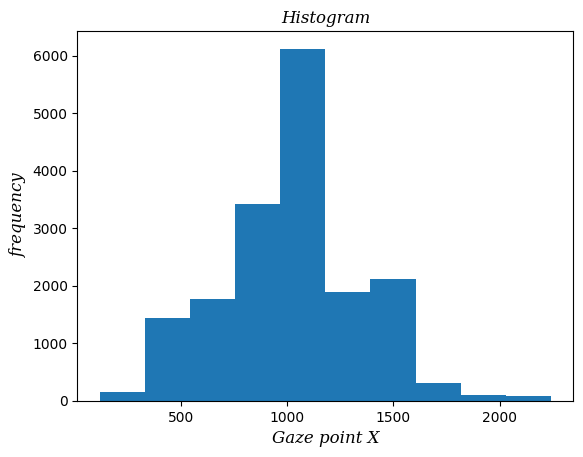

In [30]:
plt.hist(df['Gaze point X'])
plt.xlabel('Gaze point X',fontstyle='italic',fontfamily='serif',fontsize=12)
plt.ylabel('frequency',fontstyle='italic',fontfamily='serif',fontsize=12)
plt.title('Histogram',fontstyle='italic',fontfamily='serif',fontsize=12)

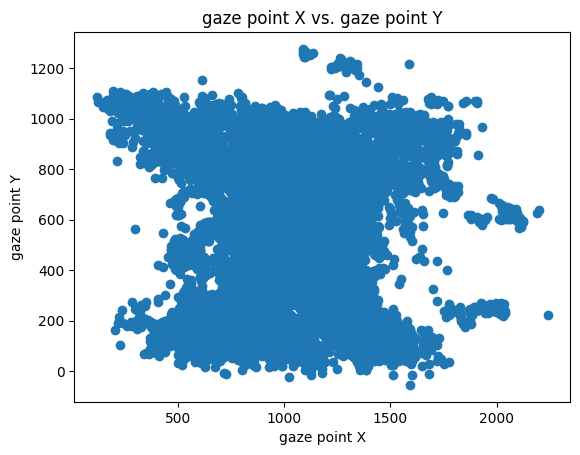

In [36]:
# create scatter plot for fixation point X vs Fixation point Y
plt.scatter(df['Gaze point X'], df['Gaze point Y'])

# set plot title and axis labels
plt.title('gaze point X vs. gaze point Y')
plt.xlabel('gaze point X')
plt.ylabel('gaze point Y')

# display plot
plt.show()

array([[<Axes: title={'center': 'index'}>,
        <Axes: title={'center': 'Computer timestamp'}>,
        <Axes: title={'center': 'Participant'}>,
        <Axes: title={'center': 'Recording name'}>],
       [<Axes: title={'center': 'Gaze point X'}>,
        <Axes: title={'center': 'Gaze point Y'}>,
        <Axes: title={'center': 'Pupil diameter left'}>,
        <Axes: title={'center': 'Pupil diameter right'}>],
       [<Axes: title={'center': 'Gaze event duration'}>,
        <Axes: title={'center': 'Eye movement type index'}>,
        <Axes: title={'center': 'Left pupil (max-mean)'}>,
        <Axes: title={'center': 'Right pupil (max-mean)'}>],
       [<Axes: title={'center': 'Left pupil (mean-min)'}>,
        <Axes: title={'center': 'Right pupil (mean-min)'}>,
        <Axes: title={'center': 'Eye movement type_EyesNotFound'}>,
        <Axes: title={'center': 'Eye movement type_Fixation'}>],
       [<Axes: title={'center': 'Eye movement type_Saccade'}>,
        <Axes: title={'center'

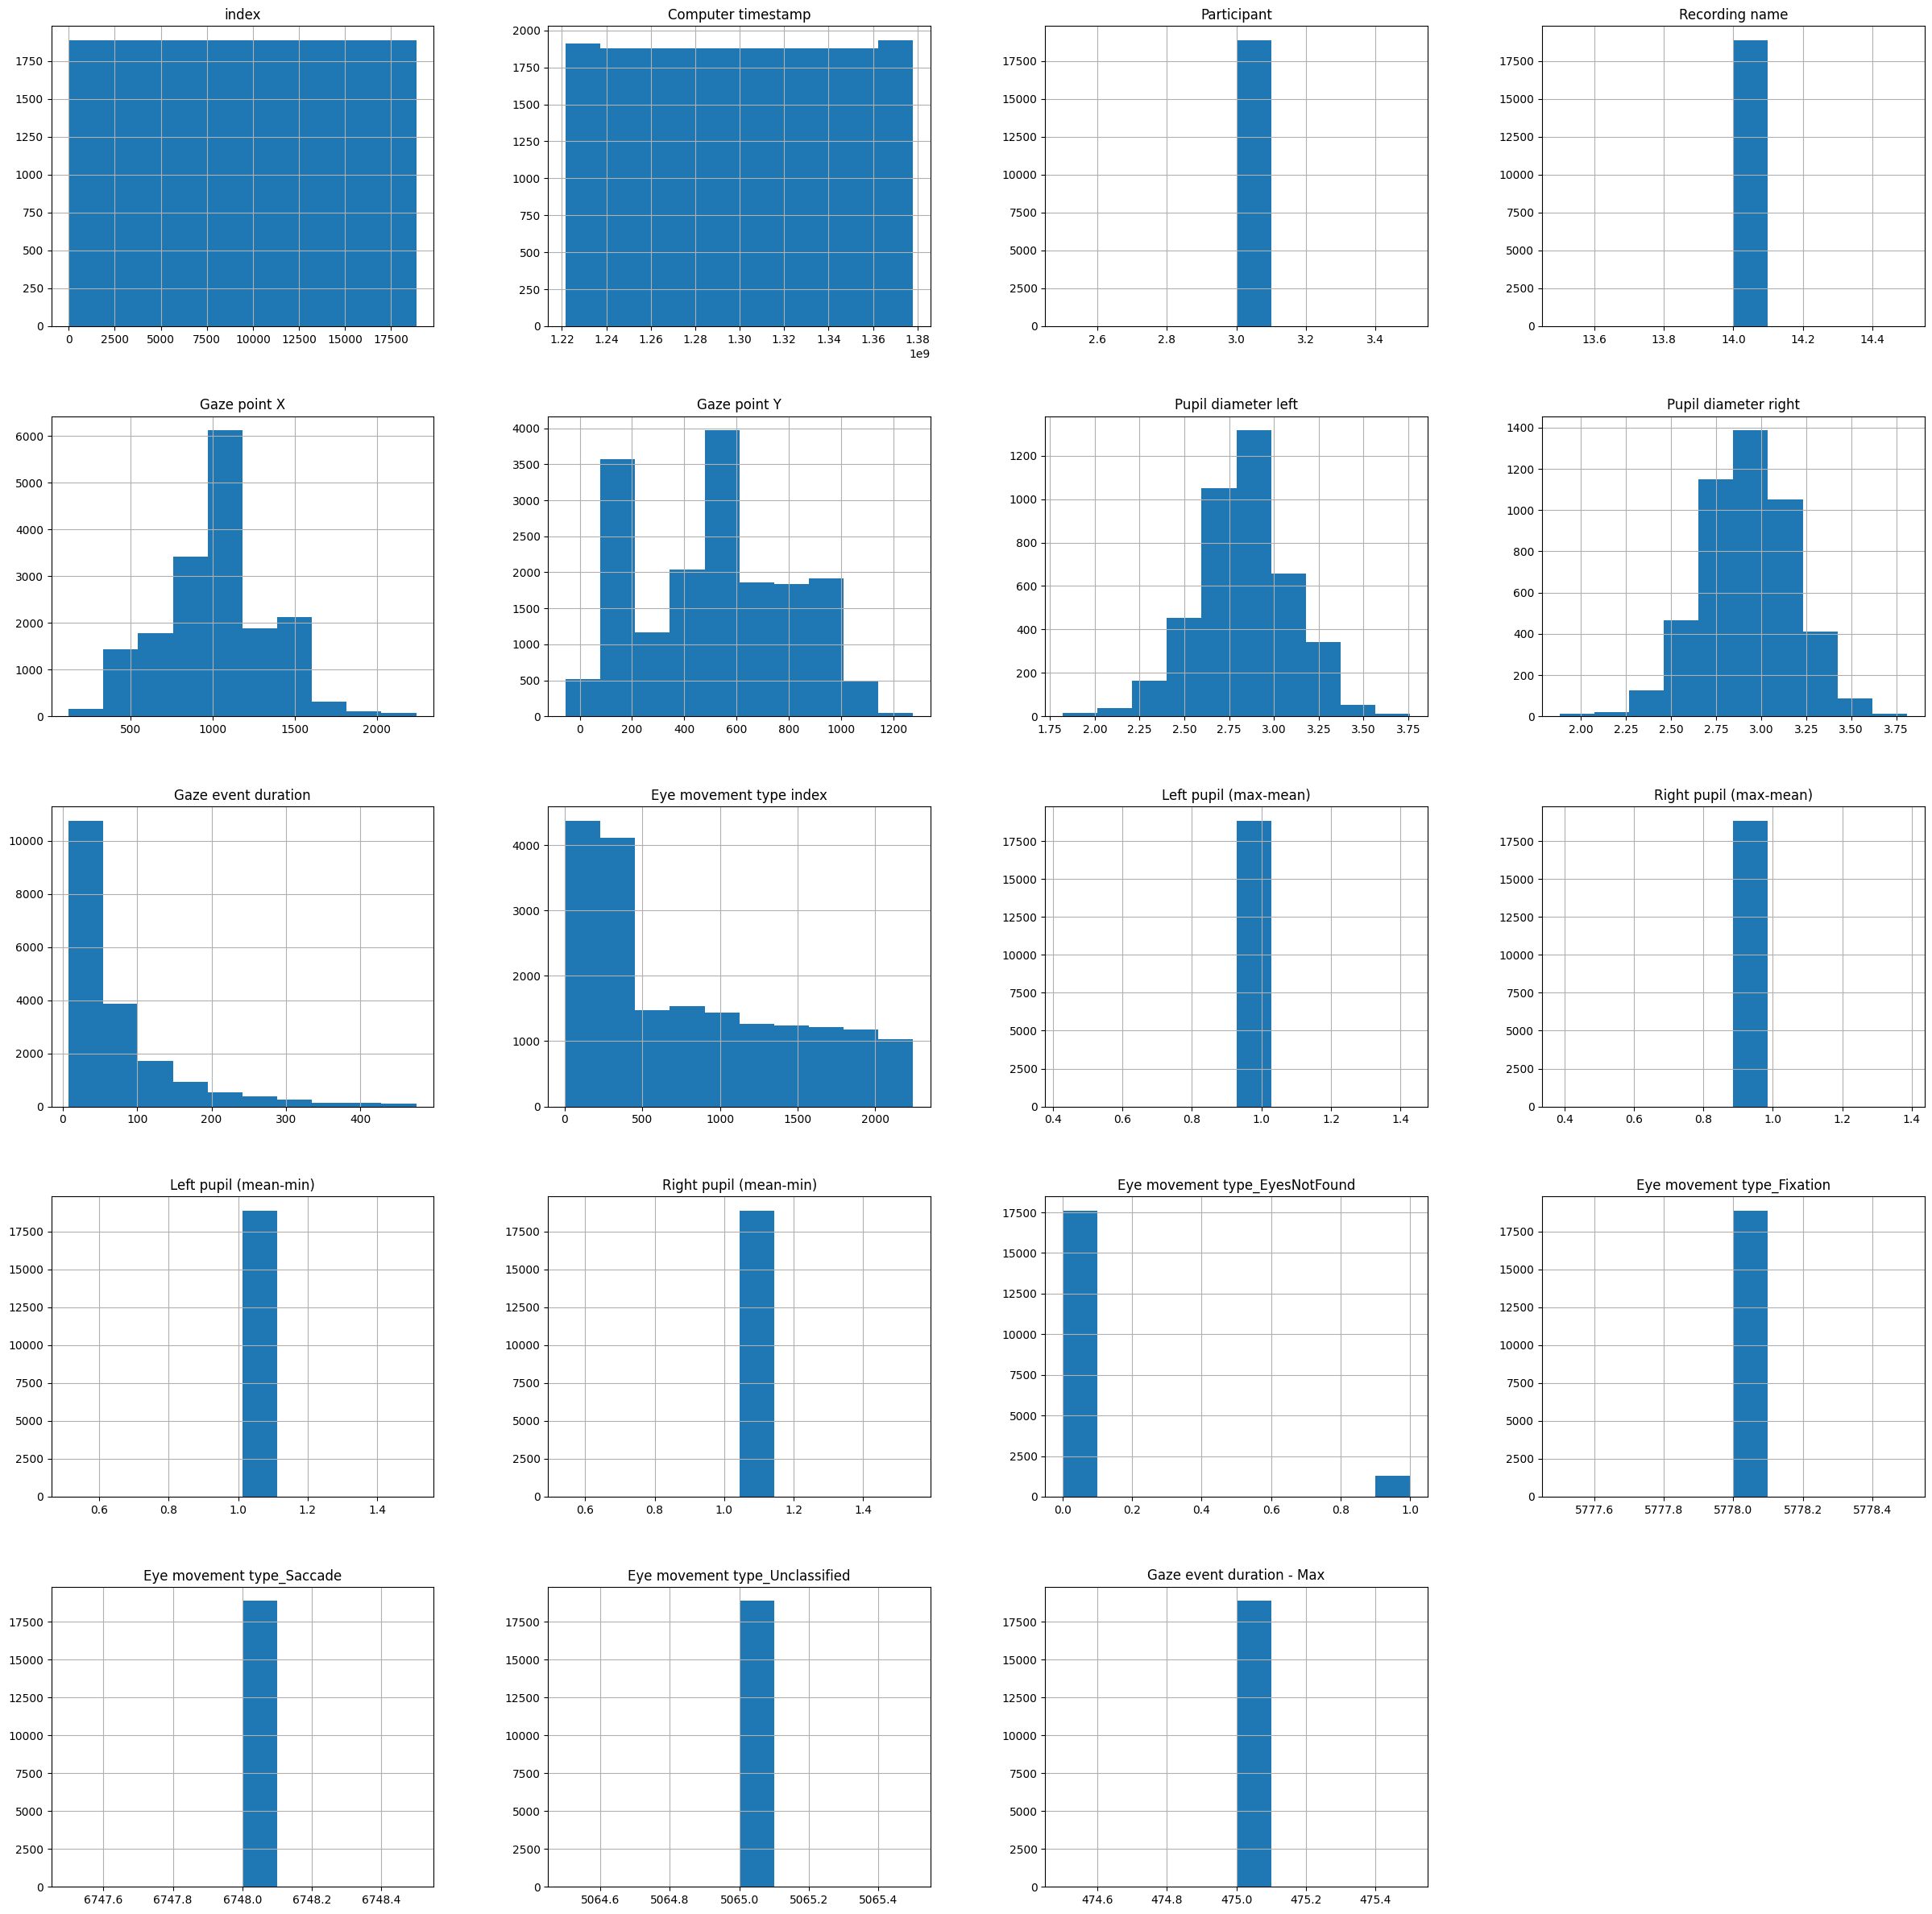

In [37]:
df.hist(figsize=(30,30))

In [ ]:
trials_data = pd.DataFrame()

In [ ]:
i=0
for df in keys:
    trials_data = pd.concat([trials_data, compress_trials(data[df],i)])
    i += 1

In [ ]:
trials_data

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,1.0,1.0,1070.355771,253.597742,1242.0,0.404153,0.589454,1.105847,0.910546,3959.0,1996.0,1115.0
1,1.0,2.0,965.955342,306.260339,717.0,0.472800,0.631475,0.637200,0.728525,4235.0,1909.0,842.0
2,3.0,11.0,1017.325455,555.689808,500.0,0.916326,0.548080,0.893674,0.771920,2070.0,2232.0,1920.0
3,3.0,12.0,984.012235,588.452621,350.0,0.900668,0.813724,1.069332,0.886276,3194.0,4429.0,4043.0
4,3.0,13.0,1005.079682,534.013693,325.0,1.114668,0.872575,1.005332,0.867425,2605.0,4969.0,3920.0
...,...,...,...,...,...,...,...,...,...,...,...,...
497,56.0,4.0,982.199465,636.944157,1067.0,0.609184,1.167508,1.080816,1.342492,1906.0,990.0,2747.0
498,58.0,2.0,937.805840,427.840598,2033.0,1.939853,1.530958,0.960147,1.049042,5636.0,913.0,501.0
499,58.0,4.0,943.514611,419.835007,2500.0,1.963222,2.037256,0.926778,1.042744,4925.0,754.0,1048.0
500,60.0,2.0,878.143282,421.078113,1433.0,0.419122,0.632128,0.760878,1.457872,5294.0,997.0,496.0


In [ ]:
#separating test group participants and the control group participants
control_group = trials_data[trials_data['Participant'] %2 != 0]
test_group = trials_data[trials_data['Participant'] %2 == 0]

In [ ]:
test_group.head()

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
360,10.0,1.0,971.247027,441.096289,1017.0,0.872613,2.897901,0.827387,1.042099,5392.0,1164.0,466.0
361,10.0,2.0,978.398370,484.556360,3476.0,1.630469,2.920098,0.979531,0.829902,5283.0,1097.0,316.0
362,10.0,3.0,998.712701,554.162540,6567.0,2.002562,2.109127,0.907438,0.750873,4444.0,1252.0,572.0
363,10.0,4.0,1003.353020,587.964254,12156.0,1.269191,0.642110,0.960809,0.967890,3389.0,849.0,294.0
364,14.0,2.0,1016.897923,481.736213,575.0,0.841228,0.882427,0.658772,1.117573,1182.0,485.0,5149.0


In [ ]:
control_group.head()


,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,1.0,1.0,1070.355771,253.597742,1242.0,0.404153,0.589454,1.105847,0.910546,3959.0,1996.0,1115.0
1,1.0,2.0,965.955342,306.260339,717.0,0.472800,0.631475,0.637200,0.728525,4235.0,1909.0,842.0
2,3.0,11.0,1017.325455,555.689808,500.0,0.916326,0.548080,0.893674,0.771920,2070.0,2232.0,1920.0
3,3.0,12.0,984.012235,588.452621,350.0,0.900668,0.813724,1.069332,0.886276,3194.0,4429.0,4043.0
4,3.0,13.0,1005.079682,534.013693,325.0,1.114668,0.872575,1.005332,0.867425,2605.0,4969.0,3920.0


In [ ]:
test_group.shape

(142, 12)

In [ ]:
control_group.shape

(360, 12)

In [ ]:
test_group = test_group.merge(emp_score, on='Participant', how='inner')
control_group = control_group.merge(emp_score, on='Participant', how='inner')

In [ ]:
test_group.head()

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
0,10.0,1.0,971.247027,441.096289,1017.0,0.872613,2.897901,0.827387,1.042099,5392.0,1164.0,466.0,84,104,83,102,3
1,10.0,2.0,978.398370,484.556360,3476.0,1.630469,2.920098,0.979531,0.829902,5283.0,1097.0,316.0,84,104,83,102,3
2,10.0,3.0,998.712701,554.162540,6567.0,2.002562,2.109127,0.907438,0.750873,4444.0,1252.0,572.0,84,104,83,102,3
3,10.0,4.0,1003.353020,587.964254,12156.0,1.269191,0.642110,0.960809,0.967890,3389.0,849.0,294.0,84,104,83,102,3
4,14.0,2.0,1016.897923,481.736213,575.0,0.841228,0.882427,0.658772,1.117573,1182.0,485.0,5149.0,111,135,103,128,4


In [ ]:
#dropping the columns that are not required
cols = {'Participant','Recording name', 'Q_IA_og', 'Q_IA_ext', 'Q_IB_og', 'Class'}
test_group = test_group.drop(cols, axis=1)

In [ ]:
test_group.head()

,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Q_IB_ext
0,971.247027,441.096289,1017.0,0.872613,2.897901,0.827387,1.042099,5392.0,1164.0,466.0,102
1,978.398370,484.556360,3476.0,1.630469,2.920098,0.979531,0.829902,5283.0,1097.0,316.0,102
2,998.712701,554.162540,6567.0,2.002562,2.109127,0.907438,0.750873,4444.0,1252.0,572.0,102
3,1003.353020,587.964254,12156.0,1.269191,0.642110,0.960809,0.967890,3389.0,849.0,294.0,102
4,1016.897923,481.736213,575.0,0.841228,0.882427,0.658772,1.117573,1182.0,485.0,5149.0,128


In [ ]:
#dropping the columns that are not required, we are going to retain only Q_IA_ext
cols = {'Participant','Recording name', 'Q_IA_og', 'Q_IA_ext', 'Q_IB_ext', 'Class'}
control_group = control_group.drop(cols, axis=1)

In [ ]:
control_group.head()

,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Q_IB_og
0,1070.355771,253.597742,1242.0,0.404153,0.589454,1.105847,0.910546,3959.0,1996.0,1115.0,102
1,965.955342,306.260339,717.0,0.472800,0.631475,0.637200,0.728525,4235.0,1909.0,842.0,102
2,945.398773,320.944357,600.0,0.340705,0.361400,0.479295,0.738600,3987.0,2047.0,992.0,102
3,956.205589,382.697346,608.0,0.472690,0.499765,0.527310,0.510235,7003.0,3057.0,1417.0,102
4,980.634064,326.117525,633.0,0.548290,0.490739,0.471710,0.459261,4903.0,2068.0,807.0,102


In [ ]:
X = test_group.drop(['Q_IB_ext'], axis=1 )

Y = test_group['Q_IB_ext']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1, random_state=1)

In [ ]:
X_train.shape

(127, 10)

In [ ]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
#control_group_scaled = scaler.fit_transform(control_group)
#final_group_scaled = scaler.fit_transform(final_group)

In [ ]:
rf_model1 = RandomForestRegressor()
rf_model1.fit(X_train, Y_train)

RandomForestRegressor()

In [ ]:
#Cross-val score
kf = KFold(n_splits=7, random_state=None)
results=cross_val_score(rf_model1,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
rf_model1.fit(X_train, Y_train)

Cross-Val accuracy -  0.3909421328765263


RandomForestRegressor()

In [ ]:
#Test Accuracy
print('Test score - ',rf_model1.score(X_test, Y_test))

Test score -  0.5145059331900415


In [ ]:
Y_pred = rf_model1.predict(X_test)
#calculate RMSE
sqrt(mean_squared_error(Y_test, Y_pred))

12.023340356711744

In [ ]:
gb_model1 = GradientBoostingRegressor()
gb_model1.fit(X_train, Y_train)

GradientBoostingRegressor()

In [ ]:
#Cross-val score
kf = KFold(n_splits=7, random_state=None)
results=cross_val_score(gb_model1,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
gb_model1.fit(X_train, Y_train)

Cross-Val accuracy -  0.37976628212775493


GradientBoostingRegressor()

In [ ]:
print('Test score - ',gb_model1.score(X_test, Y_test))

Test score -  0.5404986748046603


In [ ]:
Y_pred = gb_model1.predict(X_test)
#calculate RMSE
sqrt(mean_squared_error(Y_test, Y_pred))

11.697055808628273

In [ ]:
X = control_group.drop(['Q_IB_og'], axis=1 )

Y = control_group['Q_IB_og']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1, random_state=1)

In [ ]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
#control_group_scaled = scaler.fit_transform(control_group)
#final_group_scaled = scaler.fit_transform(final_group)

In [ ]:
rf_model2 = RandomForestRegressor()
rf_model2.fit(X_train, Y_train)

RandomForestRegressor()

In [ ]:
#Cross-val score
kf = KFold(n_splits=10, random_state=None)
results=cross_val_score(rf_model2,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
rf_model2.fit(X_train, Y_train)

Cross-Val accuracy -  0.5812747008237422


RandomForestRegressor()

In [ ]:
print('Test score - ',rf_model2.score(X_test, Y_test))

Test score -  0.7693077856054228


In [ ]:
Y_pred = rf_model2.predict(X_test)
#calculate RMSE
sqrt(mean_squared_error(Y_test, Y_pred))

4.086748231921207

In [ ]:
gb_model2 = GradientBoostingRegressor()
gb_model2.fit(X_train, Y_train)

GradientBoostingRegressor()

In [ ]:
#Cross-val score
kf = KFold(n_splits=10, random_state=None)
results=cross_val_score(gb_model2,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
gb_model2.fit(X_train, Y_train)

Cross-Val accuracy -  0.5273645766263104


GradientBoostingRegressor()

In [ ]:
print('Test score - ',gb_model2.score(X_test, Y_test))

Test score -  0.7474467257121108


In [ ]:
Y_pred = gb_model2.predict(X_test)
#calculate RMSE
sqrt(mean_squared_error(Y_test, Y_pred))

4.27600216274979

In [ ]:
trials_data.head()

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,1.0,1.0,1070.355771,253.597742,1242.0,0.404153,0.589454,1.105847,0.910546,3959.0,1996.0,1115.0
1,1.0,2.0,965.955342,306.260339,717.0,0.472800,0.631475,0.637200,0.728525,4235.0,1909.0,842.0
2,3.0,11.0,1017.325455,555.689808,500.0,0.916326,0.548080,0.893674,0.771920,2070.0,2232.0,1920.0
3,3.0,12.0,984.012235,588.452621,350.0,0.900668,0.813724,1.069332,0.886276,3194.0,4429.0,4043.0
4,3.0,13.0,1005.079682,534.013693,325.0,1.114668,0.872575,1.005332,0.867425,2605.0,4969.0,3920.0


In [ ]:
trials_data_emp = trials_data.merge(emp_score, on='Participant', how='inner')
trials_data_emp

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
0,1.0,1.0,1070.355771,253.597742,1242.0,0.404153,0.589454,1.105847,0.910546,3959.0,1996.0,1115.0,101,125,102,127,4
1,1.0,2.0,965.955342,306.260339,717.0,0.472800,0.631475,0.637200,0.728525,4235.0,1909.0,842.0,101,125,102,127,4
2,1.0,3.0,945.398773,320.944357,600.0,0.340705,0.361400,0.479295,0.738600,3987.0,2047.0,992.0,101,125,102,127,4
3,1.0,4.0,956.205589,382.697346,608.0,0.472690,0.499765,0.527310,0.510235,7003.0,3057.0,1417.0,101,125,102,127,4
4,1.0,5.0,980.634064,326.117525,633.0,0.548290,0.490739,0.471710,0.459261,4903.0,2068.0,807.0,101,125,102,127,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,20.0,4.0,873.097778,348.956349,4048.0,1.205493,1.016968,1.304507,1.303032,4504.0,1100.0,805.0,98,117,109,132,4
498,22.0,1.0,843.135480,489.088460,1458.0,0.460149,0.477857,1.649851,1.052143,4097.0,966.0,1278.0,90,108,98,121,3
499,22.0,2.0,778.052670,444.224280,1521.0,0.774306,0.555542,1.495694,1.354458,4200.0,1245.0,1613.0,90,108,98,121,3
500,22.0,3.0,772.105281,409.056004,1138.0,0.570868,0.516661,1.469132,1.253339,3332.0,1063.0,1706.0,90,108,98,121,3


In [ ]:
corr = trials_data_emp.corr()
corr.style.background_gradient(cmap='coolwarm')

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
Participant,1.000000,-0.417970,-0.343831,0.019191,0.028965,0.205517,0.216797,0.167423,0.228067,0.027848,-0.239033,0.000208,-0.046690,-0.034237,-0.384211,-0.406616,-0.297015
Recording name,-0.417970,1.000000,0.191410,0.452763,0.073414,0.305148,0.231871,0.189724,0.067568,0.103059,0.150081,0.041367,-0.187305,-0.184228,0.024648,0.044695,-0.063128
Gaze point X,-0.343831,0.191410,1.000000,-0.106872,-0.103869,0.029393,-0.067179,-0.071125,-0.167768,-0.229583,-0.021264,-0.164812,-0.040703,-0.046106,0.150219,0.136282,0.169454
Gaze point Y,0.019191,0.452763,-0.106872,1.000000,-0.020912,0.250030,0.261752,0.170793,0.145333,-0.019317,0.063909,0.222915,-0.291913,-0.287426,-0.056953,-0.064190,-0.114418
Gaze event duration - Max,0.028965,0.073414,-0.103869,-0.020912,1.000000,0.167313,0.082141,0.100410,0.074663,0.273780,0.062234,-0.013769,-0.095296,-0.096485,-0.194891,-0.194032,-0.155521
Left pupil (max-mean),0.205517,0.305148,0.029393,0.250030,0.167313,1.000000,0.803982,0.498456,0.419893,0.136145,0.036894,0.094245,-0.151522,-0.205535,-0.066560,-0.100230,-0.013987
Right pupil (max-mean),0.216797,0.231871,-0.067179,0.261752,0.082141,0.803982,1.000000,0.521663,0.434296,0.138169,0.020686,0.153497,-0.079363,-0.128144,-0.059204,-0.095006,-0.002138
Left pupil (mean-min),0.167423,0.189724,-0.071125,0.170793,0.100410,0.498456,0.521663,1.000000,0.665176,0.037342,-0.041117,0.162821,-0.155480,-0.235813,-0.061829,-0.118355,-0.095860
Right pupil (mean-min),0.228067,0.067568,-0.167768,0.145333,0.074663,0.419893,0.434296,0.665176,1.000000,0.076337,-0.003441,0.203244,-0.081962,-0.135006,-0.085459,-0.124620,-0.100130
Eye movement type_Fixation,0.027848,0.103059,-0.229583,-0.019317,0.273780,0.136145,0.138169,0.037342,0.076337,1.000000,0.647033,0.015541,0.002471,0.035626,-0.033902,-0.000103,0.004787


In [ ]:
#We are going to retain only Class amongst the empathy scores as the target variable
#dropping the columns that are not required
cols = {'Participant','Recording name', 'Q_IA_og', 'Q_IA_ext', 'Q_IB_og', 'Q_IB_ext'}
trials_data_emp = trials_data_emp.drop(cols, axis=1)

In [ ]:
X = trials_data_emp.drop(['Class'], axis=1 )

Y = trials_data_emp['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1, random_state=1)

In [ ]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
rf_cl = RandomForestClassifier()
rf_cl.fit(X_train, Y_train)

RandomForestClassifier()

In [ ]:
#Cross-val score
kf = KFold(n_splits=10, random_state=None)
results=cross_val_score(rf_cl,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
rf_cl.fit(X_train, Y_train)

Cross-Val accuracy -  0.8158454106280193


RandomForestClassifier()

In [ ]:
Y_predict = rf_cl.predict(X_test)
print('Test score - ',rf_cl.score(X_test, Y_test))

Test score -  0.7843137254901961


In [ ]:
pd.DataFrame(data={'Predictions': Y_predict, 'Actual': Y_test})

,Predictions,Actual
306,3,3
342,3,3
47,4,4
67,3,3
376,3,3
...,...,...
497,2,4
358,3,3
372,3,3
102,3,3
